## Model Re-Training @ Scale - Middle Loop 

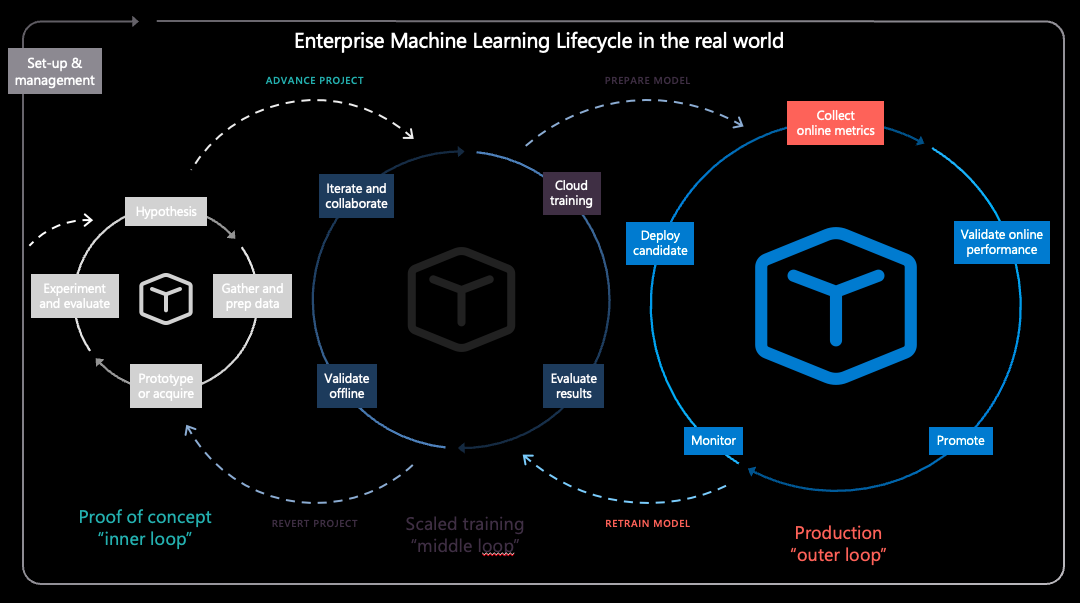

## Prerequisites

* If you opened this notebook from Azure Machine Learning studio, you need a compute instance to run the code. If you don't have a compute instance, select **Create compute** on the toolbar to first create one.  You can use all the default settings.  

    ![Create compute](./media/create-compute.png)

* If you're seeing this notebook elsewhere, complete [Create resources you need to get started](https://docs.microsoft.com/azure/machine-learning/quickstart-create-resources) to create an Azure Machine Learning workspace and a compute instance.

## Set your kernel

* If your compute instance is stopped, start it now.  
        
    ![Start compute](./media/start-compute.png)

* Once your compute instance is running, make sure the that the kernel, found on the top right, is `Python 3.10 - SDK v2`.  If not, use the dropdown to select this kernel.

    ![Set the kernel](./media/set-kernel.png)

## Use a command job to train a model in Azure Machine Learning

To train a model, you need to submit a *job*. The type of job you'll submit in this tutorial is a *command job*. Azure Machine Learning offers several different types of jobs to train models. Users can select their method of training based on complexity of the model, data size, and training speed requirements.  In this tutorial, you'll learn how to submit a *command job* to run a *training script*. 

A command job is a function that allows you to submit a custom training script to train your model. This can also be defined as a custom training job. A command job in Azure Machine Learning is a type of job that runs a script or command in a specified environment. You can use command jobs to train models, process data, or any other custom code you want to execute in the cloud. 

In this tutorial, we'll focus on using a command job to create a custom training job that we'll use to train a model. For any custom training job, the below items are required:

* compute resource (usually a compute cluster, which we recommend for scalability)
* environment
* data
* command job 
* training script


In this tutorial we'll provide all these items for our example: creating a classifier to predict customers who have a high likelihood of defaulting on credit card payments.


## Create handle to workspace

Before we dive in the code, you need a way to reference your workspace. You'll create `ml_client` for a handle to the workspace.  You'll then use `ml_client` to manage resources and jobs.

In the next cell, enter your Subscription ID, Resource Group name and Workspace name. To find these values:

1. In the upper right Azure Machine Learning studio toolbar, select your workspace name.
1. Copy the value for workspace, resource group and subscription ID into the code.
1. You'll need to copy one value, close the area and paste, then come back for the next one.

In [1]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

import os 
from dotenv import load_dotenv

# load the environment variables from .env
load_dotenv()

# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

> [!NOTE]
> Creating MLClient will not connect to the workspace. The client initialization is lazy, it will wait for the first time it needs to make a call (this will happen in the next code cell).

## Configure a training job using the command function

You create an Azure Machine Learning *command job* to train a model for credit default prediction. The command job runs a *training script* in a specified environment on a specified compute resource.  You've already created the environment and the compute cluster.  Next you'll create the training script. In our specific case, we're training our dataset to produce a classifier using the `GradientBoostingClassifier` model. 

The *training script* handles the data preparation, training and registering of the trained model. The method `train_test_split` handles splitting the dataset into test and training data. In this tutorial, you'll create a Python training script. 

Command jobs can be run from CLI, Python SDK, or studio interface. In this tutorial, you'll use the Azure Machine Learning Python SDK v2 to create and run the command job.

## Run training script via command job, use csv dataset



In [8]:
from azure.ai.ml import command
from azure.ai.ml import Input

registered_model_name = "credit_defaults_model"

job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="azureml:credit-card:2023.09.06.135022",
            # path="azureml:credit-card:2023.04.24.161942_cleaned",
        ),
        test_train_ratio=0.3,
        learning_rate=0.25,
        registered_model_name=registered_model_name,
    ),
    code="./src/",  # location of source code
    command="python main.py --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}} --learning_rate ${{inputs.learning_rate}} --registered_model_name ${{inputs.registered_model_name}}",
    environment="credit-card-scikit-38@latest",
    compute="cpu-cluster",
    display_name="03b_ReTrain_Model_CSV_credit_default_prediction",
)

## Submit the job 

It's now time to submit the job to run in Azure Machine Learning studio. This time you'll use `create_or_update`  on `ml_client`. `ml_client` is a client class that allows you to connect to your Azure subscription using Python and interact with Azure Machine Learning services. `ml_client` allows you to submit your jobs using Python.

In [9]:
ml_client.create_or_update(job)

Experiment,Name,Type,Status,Details Page
amlv2_workshop,quiet_moon_bl9msmqqk1,command,Starting,Link to Azure Machine Learning studio


## Use Parquet dataset for Model Training



In [10]:
from azure.ai.ml import command
from azure.ai.ml import Input

registered_model_name = "credit_defaults_model"

job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="azureml:credit-card:2023.09.06.135022_cleaned",
        ),
        test_train_ratio=0.3,
        learning_rate=0.25,
        registered_model_name=registered_model_name,
    ),
    code="./src/",  # location of source code
    command="python main_parquet.py --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}} --learning_rate ${{inputs.learning_rate}} --registered_model_name ${{inputs.registered_model_name}}",
    environment="credit-card-scikit-38@latest",
    compute="cpu-cluster",
    display_name="03b_ReTrain_Model_Parquet_credit_default_prediction",
)
ml_client.create_or_update(job)

Experiment,Name,Type,Status,Details Page
amlv2_workshop,clever_oyster_s90r058ssy,command,Starting,Link to Azure Machine Learning studio
